In [33]:
%matplotlib inline

import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import kendalltau
import numpy as np

import phate
import scanpy as sc


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
# import pseudotime data for WT, astrocytes
print('Pseudotime files:')
for i, f in enumerate(glob.glob('/home/ngr4/project/scnd/results/*traj*csv')): # need traj in there
    print('  #{}:'.format(i), f)

Pseudotime files:
  #0: /home/ngr4/project/scnd/results/monocole_traj-umapcoords.csv


In [3]:
fname = '/home/ngr4/project/scnd/results/monocole_traj-umapcoords.csv'
pfp = '/home/ngr4/project/scnd/results/'
md_fname = os.path.join('/home/ngr4/project/scnd/results/', 'astrocytes_cellmd.csv')

# requires some customization
df = pd.read_csv(fname, index_col=0)
df.columns = ['Pseudotime', 'UMAP 1', 'UMAP 2']

# load metadata 
dt = pd.read_csv(md_fname)

# merge to get cell_id
df = df.reset_index()
dt = dt.merge(df, left_index=True, right_index=True)

# add timepoint as int for regressions
dt['timepoint_int'] = [int(i.split('wk')[0]) for i in dt['timepoint']]

# load adata
adata = sc.read('/home/ngr4/project/scnd/data/processed/astrocyte_210519.h5ad')

In [4]:
savefigs = True


# aesthetics
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

In [ ]:
# NOTE: can functionalize, just need metadata df with cols = [UMAP 1, UMAP 2, timepoint_int, ]

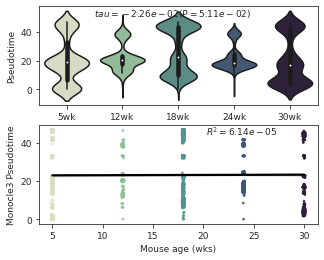

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(5, 4))
sns.violinplot(x='timepoint', y='Pseudotime', ax=ax[0], data=dt, dodge=False, hue='timepoint', palette=cmap_wt)
ax[0].set_xlabel('')
ax[0].legend().set_visible(False)
sns.regplot(x='timepoint_int', y='Pseudotime', data=dt, ax=ax[1], scatter=False, color='k')
ax[1].scatter(dt['timepoint_int']+np.random.uniform(-0.1, 0.1, size=(dt.shape[0], )),
           dt['Pseudotime'], 
           c=dt['timepoint'].map(cmap_wt), s=3, alpha=0.8, rasterized=True)
r, p_pearson = pearsonr(dt['timepoint_int'], dt['Pseudotime'])
tau, p_kendall = kendalltau(dt['timepoint_int'], dt['Pseudotime'])
R2 = r**2
ax[0].text(0.2, 0.9, '$tau={:.2e} (P={:.2e})$'.format(tau, p_kendall), transform=ax[0].transAxes, weight='bold',)
ax[1].text(0.6, 0.9, '$R^2={:.2e}$'.format(R2), transform=ax[1].transAxes, weight='bold',)
ax[1].set_ylabel('Monocle3 Pseudotime')
ax[1].set_xlabel('Mouse age (wks)')

if savefigs:
    fig.savefig(os.path.join(pfp, 'violin_scatterplot_monocle3pseudotVtimepoint.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


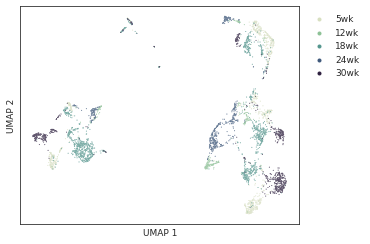

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(dt['UMAP 1'], dt['UMAP 2'], hue=dt['timepoint'], palette=cmap_wt, s=1, rasterized=True, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP 1')
ax.legend(bbox_to_anchor=(1.01, 1))

if savefigs:
    fig.savefig('/home/ngr4/project/scnd/results/monocle_umap_bytimepoint.pdf', bbox_inches='tight', dpi=600)

In [6]:
# add 1D phate plots
save_adata = False
if not save_adata:
    # need to re-run phate if not in there
    adata.obsm['1dphate'] = phate.PHATE(n_components=1, gamma=0).fit_transform(adata.X)
    
# write out to use with other ones?
if save_adata:
    adata.write('/home/ngr4/project/scnd/data/processed/astrocyte_210519.h5ad')

In [37]:
savefigs = True

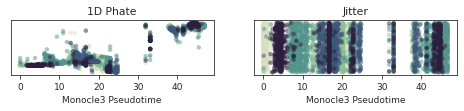

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(8,1))
sns.scatterplot(x=dt['Pseudotime'], y=adata.obsm['1dphate'].squeeze(), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[0], rasterized=True)
ax[0].set_xlabel('Monocle3 Pseudotime')
ax[0].set_yticks([])
ax[0].legend().set_visible(False)
ax[0].set_title('1D Phate')

sns.scatterplot(x=dt['Pseudotime'], y=np.random.uniform(-1, 1, size=(dt.shape[0],)), hue=adata.obs['timepoint'].to_list(), palette=cmap_wt,
                s=20, alpha=0.5, linewidth=0, ax=ax[1], rasterized=True)
ax[1].set_xlabel('Monocle3 Pseudotime')
ax[1].set_yticks([])
ax[1].legend().set_visible(False)
ax[1].set_title('Jitter')

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplots_phateVmonoclepseudot.pdf'), dpi=600, bbox_inches='tight')
    savefigs = False